In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from amplpy import AMPL
import matplotlib.lines as mlines

In [4]:
def get_all_index_returns(qs, ms):
    correlations_dict = {}
    returns = pd.read_csv("returns.csv", index_col=0)
    sp100_returns = pd.read_csv('sp100returns.csv')
    combined = sp100_returns[['Portfolio_Return']].rename(columns={'Portfolio_Return': 'SP100'})
    for m in ms:
        # Prepare out-of-sample data
        split_point = int(0.7 * len(returns))
        out_sample = returns.iloc[split_point:].copy()
        n_rows = len(out_sample)
        period_length = n_rows // m
        periods = np.repeat(np.arange(1, m + 1), period_length)
        remainder = n_rows - len(periods)
        if remainder > 0:
            periods = np.append(periods, [m] * remainder)
        out_sample['period'] = periods
        out_sample_tall = out_sample.reset_index().melt(id_vars=["Date", "period"], var_name="Ticker", value_name="Return")
        

        # IS windows
        is_windows = []
        for i in range(1, m + 1):    
            start_date = out_sample[out_sample['period'] == i].index[0]
            is_window = returns.loc[:start_date].iloc[-split_point:]
            is_windows.append(is_window)

        for q in qs:
            results = []
            for i in range(m):
                window_returns = is_windows[i]
                correlations = window_returns.corr()

                with open("data.txt", "w") as f:
                    f.write("set STOCKS := " + " ".join(correlations.columns) + " ;\n\n")
                    f.write("param q := " + str(q) + " ;\n\n")
                    f.write("param r:\n    " + " ".join(correlations.columns) + " :=\n")
                    for t1 in correlations.columns:
                        row = " ".join(f"{correlations.loc[t1, t2]:.4f}" for t2 in correlations.columns)
                        f.write(f"{t1} {row}\n")
                    f.write(";\n")

                ampl = AMPL()
                ampl.setOption('solver', 'gurobi')
                ampl.read("max_corr.txt")
                ampl.read_data("data.txt")
                ampl.solve()
                y = ampl.get_variable("y").get_values().to_pandas()
                selected = y[y["y.val"] == 1]
                results.append(selected.index.tolist())

            # WEIGHTS HERE
            periods_all, tickers_all, weights_all = [], [], []
            for i in range(m):
                market_caps = {}
                for ticker in results[i]:
                    try:
                        info = yf.Ticker(ticker).info
                        market_caps[ticker] = info.get('marketCap', 0)
                    except Exception as e:
                        market_caps[ticker] = 0
                total_market_value = sum(market_caps.values())
                for ticker in results[i]:
                    cap = market_caps[ticker]
                    weight = cap / total_market_value if total_market_value > 0 else 0
                    periods_all.append(i + 1)
                    tickers_all.append(ticker)
                    weights_all.append(weight)

            weights_df = pd.DataFrame({
                'period': periods_all,
                'Ticker': tickers_all,
                'Weight': weights_all
            })
            # WEIGHTS END HERE

            portfolio = pd.merge(out_sample_tall, weights_df, on=['period', 'Ticker'], how='inner')
            portfolio['Weighted_Return'] = portfolio['Return'] * portfolio['Weight']
            portfolio_return = portfolio.groupby('Date')['Weighted_Return'].sum().reset_index()
            portfolio_return = portfolio_return.rename(columns={'Weighted_Return': 'Portfolio_Return'})
            label = "(" + str(q) +"," + str(m) + ")"
            combined[label] = portfolio_return['Portfolio_Return']
            correlation = sp100_returns['Portfolio_Return'].corr(portfolio_return['Portfolio_Return'])
            correlations_dict[(q,m)] = correlation

    return correlations_dict, combined

In [25]:
corrs, indexes = get_all_index_returns([1,5, 10, 25, 50], [1, 2, 4, 6, 12])

Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 59.9153
3179 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 70.6261
894 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 74.4079
708 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 81.897
461 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 90.613
310 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 59.9153
3179 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 49.6146
2796 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 70.6261
894 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 61.6403
1203 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; object

In [26]:
corrs_df = pd.DataFrame(
    [(q, m, corr) for (q, m), corr in corrs.items()],
    columns=['q', 'm', 'Correlation']
)

corrs_df.to_csv('max_correlations.csv')
indexes.to_csv('max_corr_returns.csv')

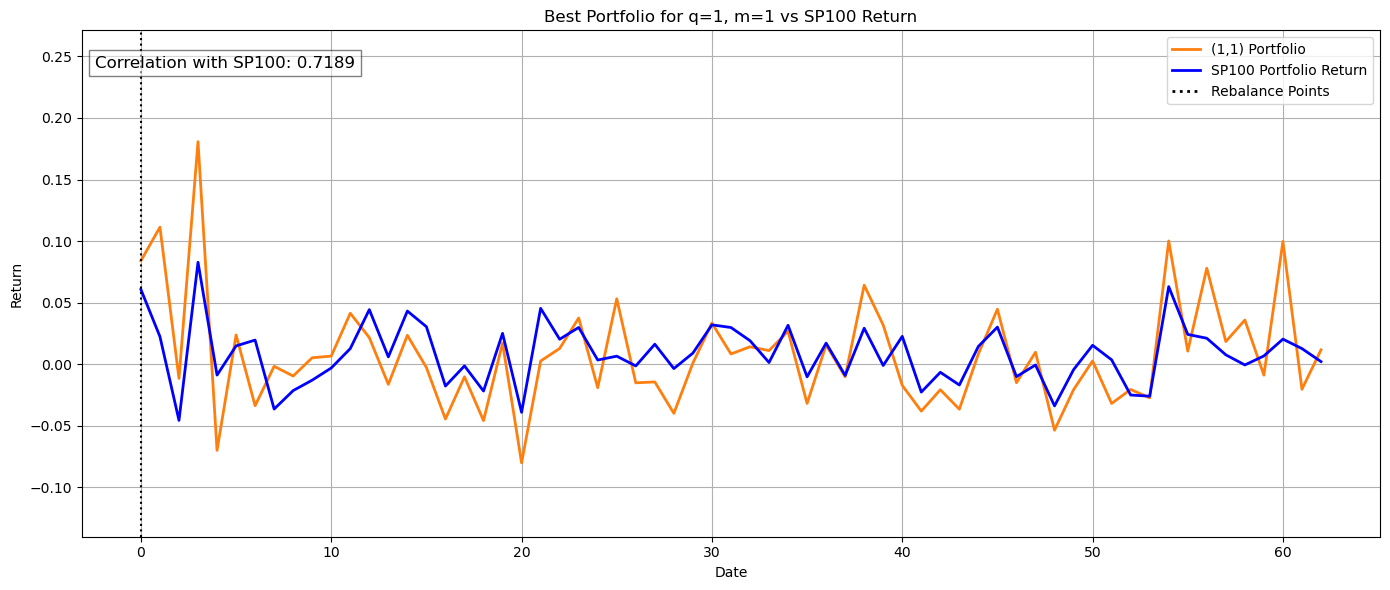

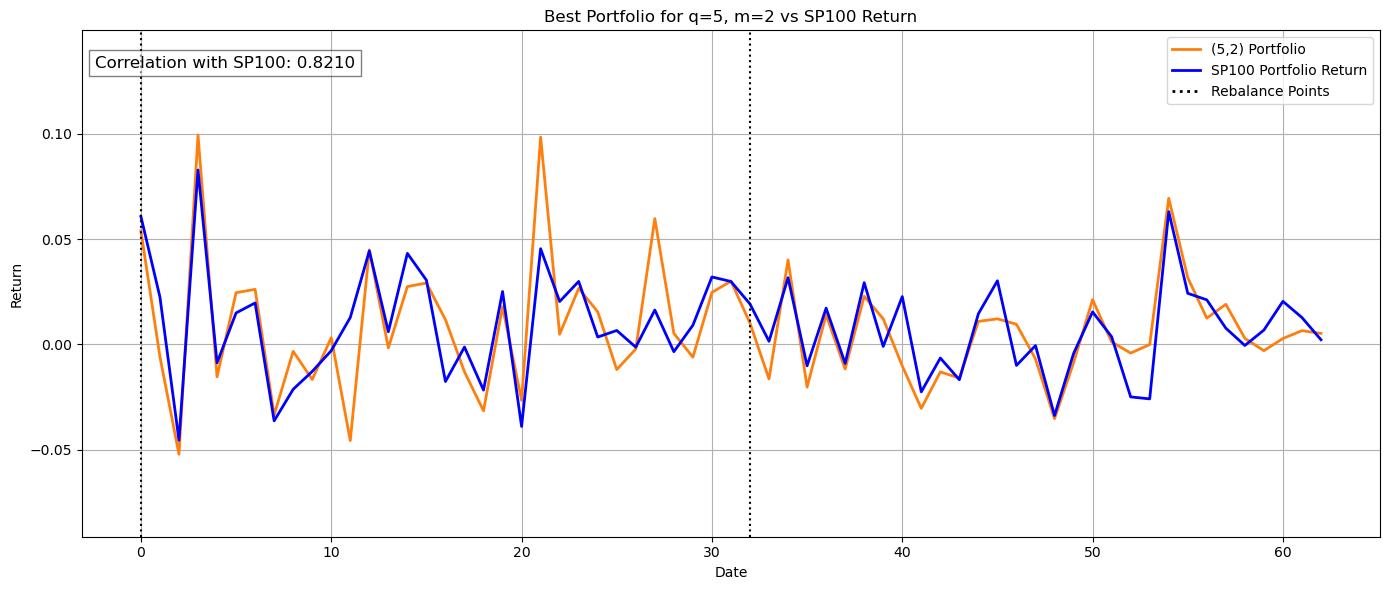

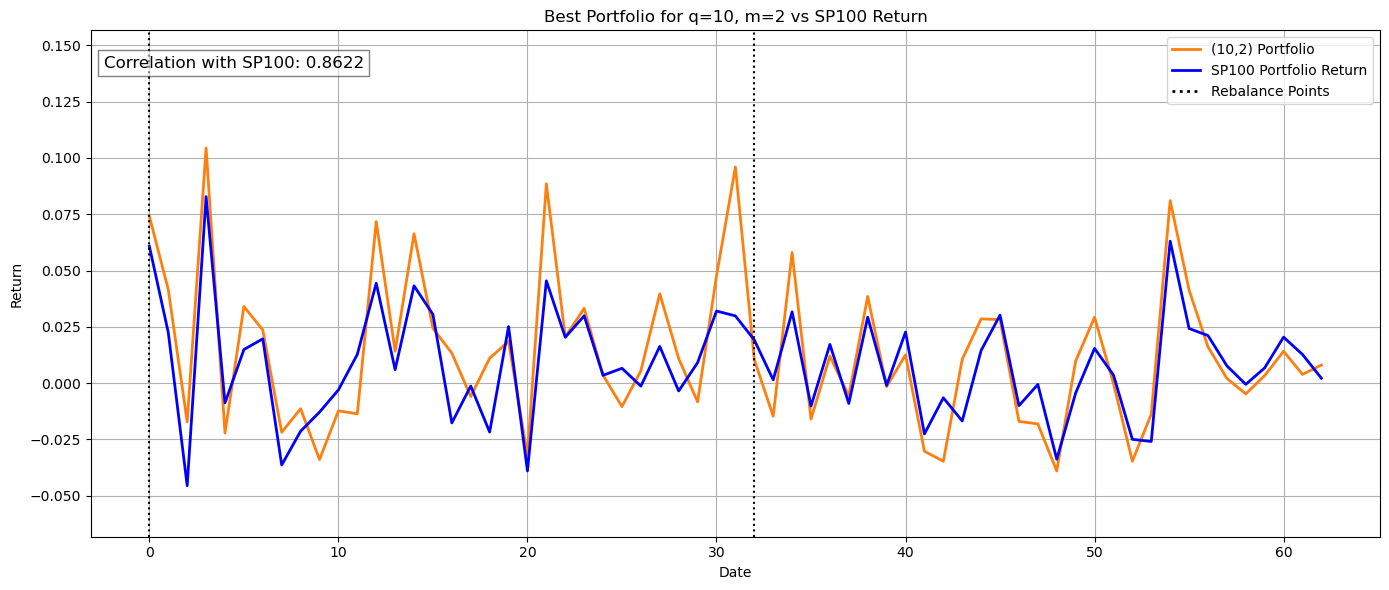

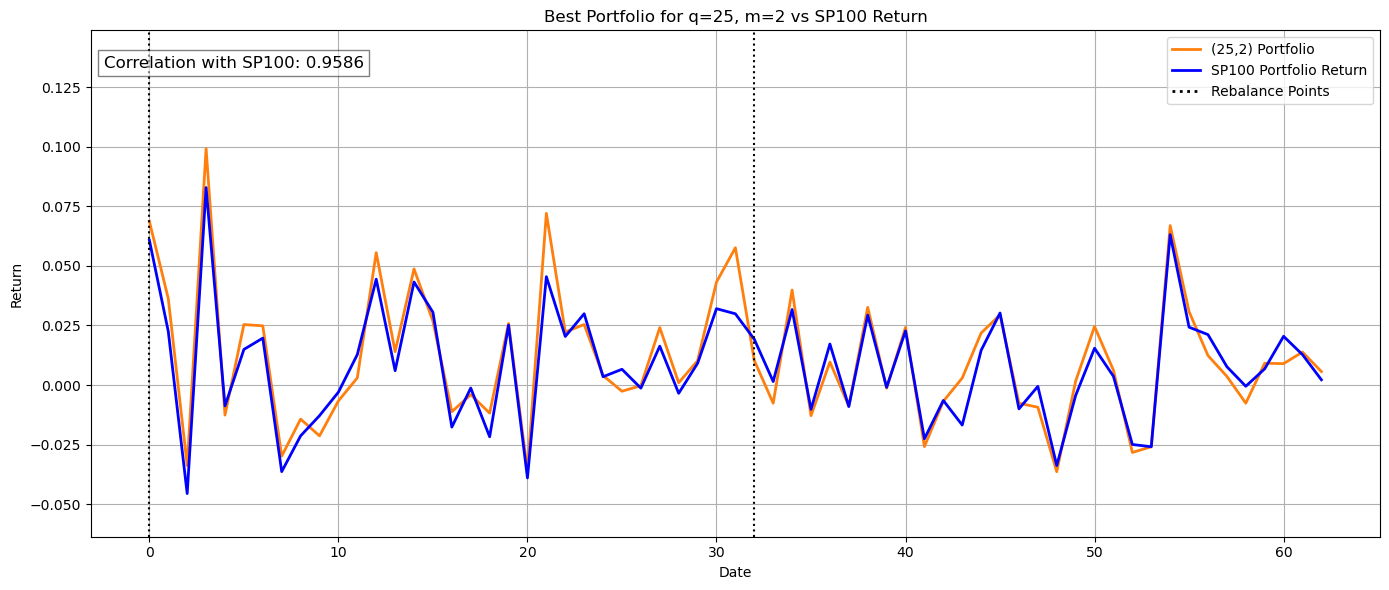

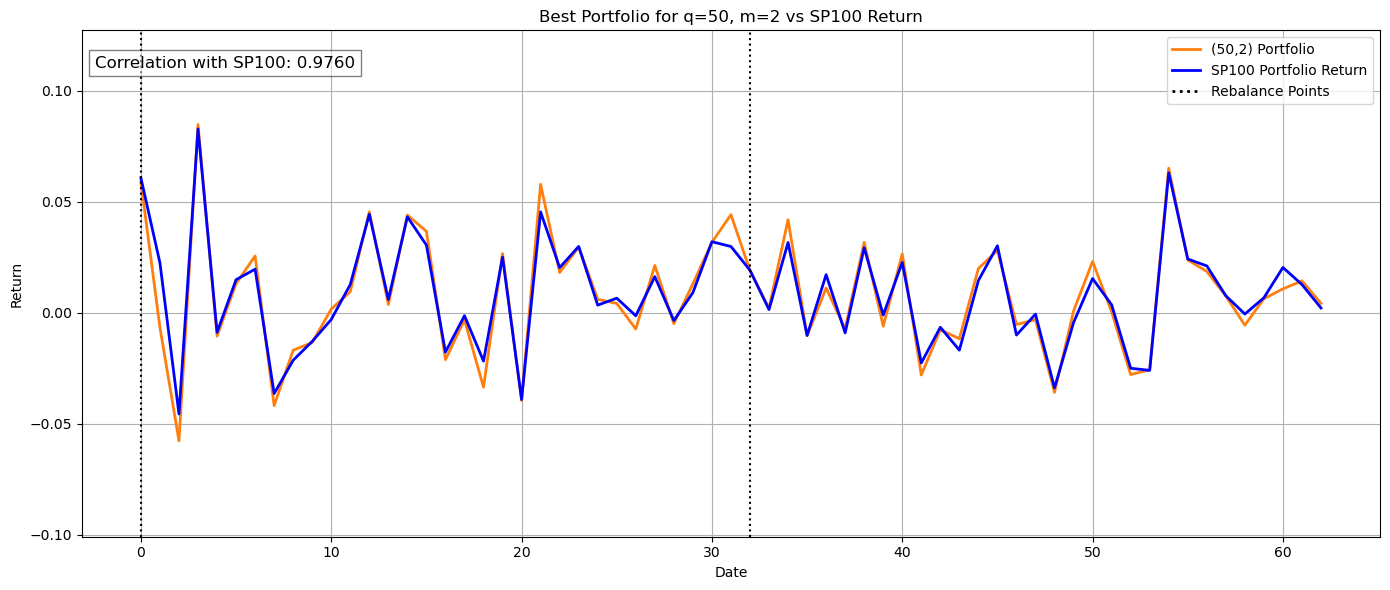

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.lines as mlines

# Read the data
corrs_df = pd.read_csv('max_correlations.csv')
indexes = pd.read_csv('max_corr_returns.csv')

# Group by q and find the best m for each q (highest correlation)
best_portfolios = corrs_df.loc[corrs_df.groupby('q')['Correlation'].idxmax()]

# Generate the labels for the best portfolios
top_labels = [f"({int(row.q)},{int(row.m)})" for _, row in best_portfolios.iterrows()]

# Plot the best portfolio for each q
for label in top_labels:
    focus_q, focus_m = eval(label)  # safe if coming from trusted source

    plt.figure(figsize=(14, 6))

    # Plot the highlighted portfolio
    plt.plot(indexes.index, indexes[label], label=f'{label} Portfolio', linewidth=2, color='tab:orange')

    # Plot SP100
    plt.plot(indexes.index, indexes['SP100'], label='SP100 Portfolio Return', linewidth=2, linestyle='-', color='blue')

    # Calculate rebalance points based on m
    rebalance_points = list(range(0, len(indexes), int(np.ceil(len(indexes) / focus_m))))
    for x in rebalance_points:
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1.5)
        
    rebalance_line = mlines.Line2D([], [], color='black', linestyle=':', linewidth=2, label='Rebalance Points')
        
    # Correlation annotation
    corr = corrs_df[(corrs_df['q'] == focus_q) & (corrs_df['m'] == focus_m)]['Correlation'].values[0]
    plt.text(
        0.01, 0.95, f'Correlation with SP100: {corr:.4f}',
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.5)
    )

    # Plot formatting
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.ylim(min(indexes[label]) * 1.75, max(indexes[label]) * 1.5)
    plt.title(f'Best Portfolio for q={focus_q}, m={focus_m} vs SP100 Return')
    plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + [rebalance_line]) 
    plt.grid(True)
    plt.tight_layout()
    plt.show()


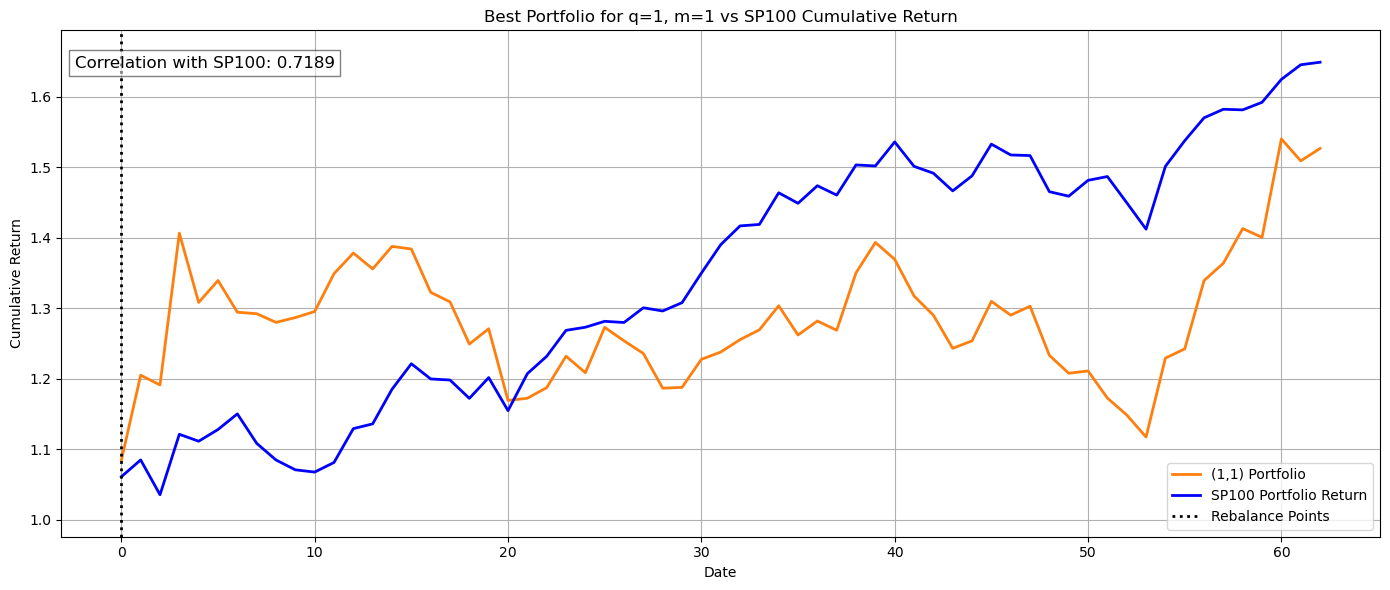

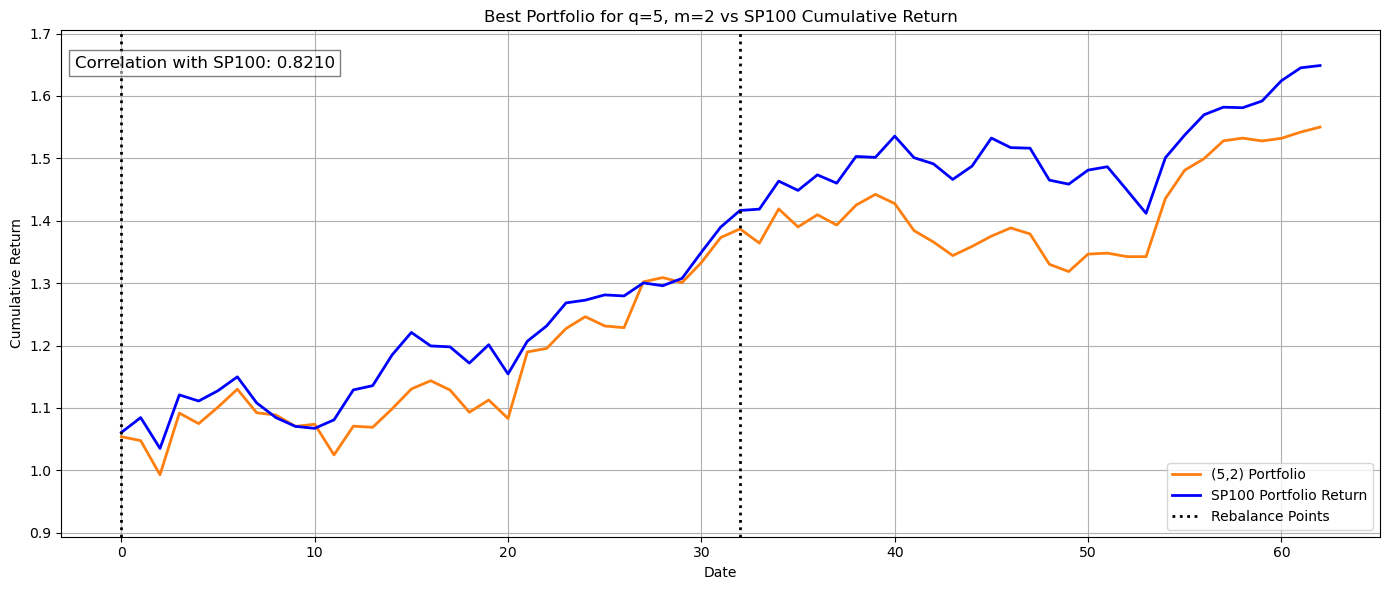

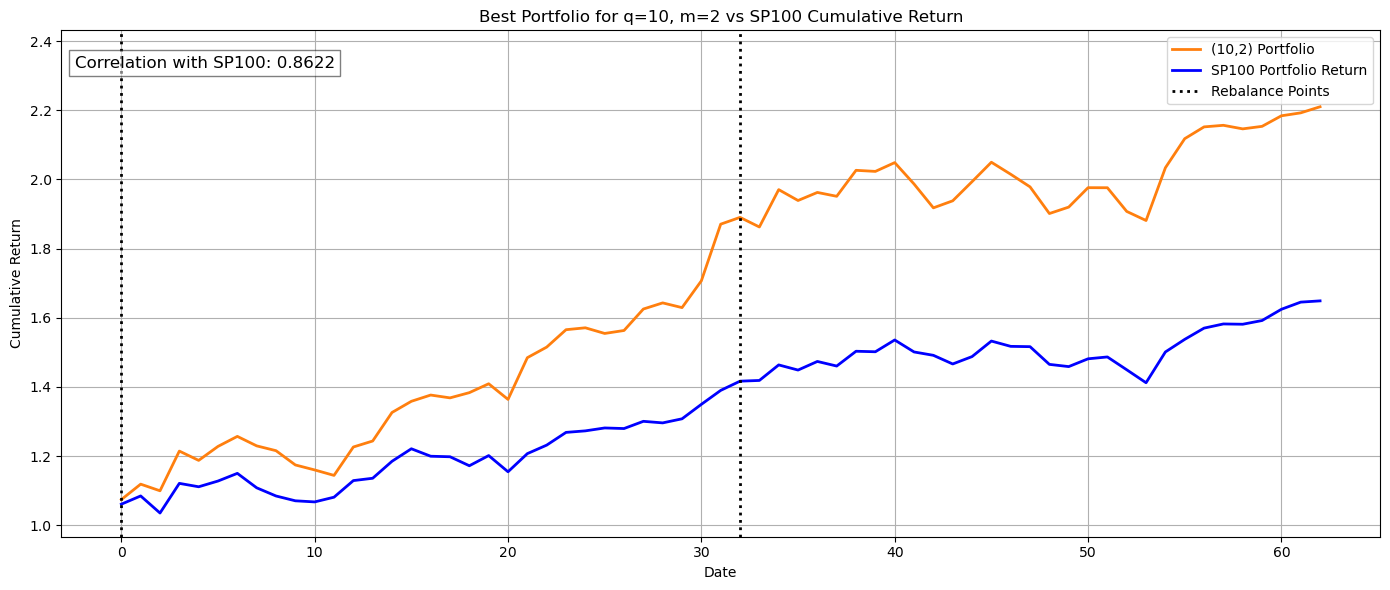

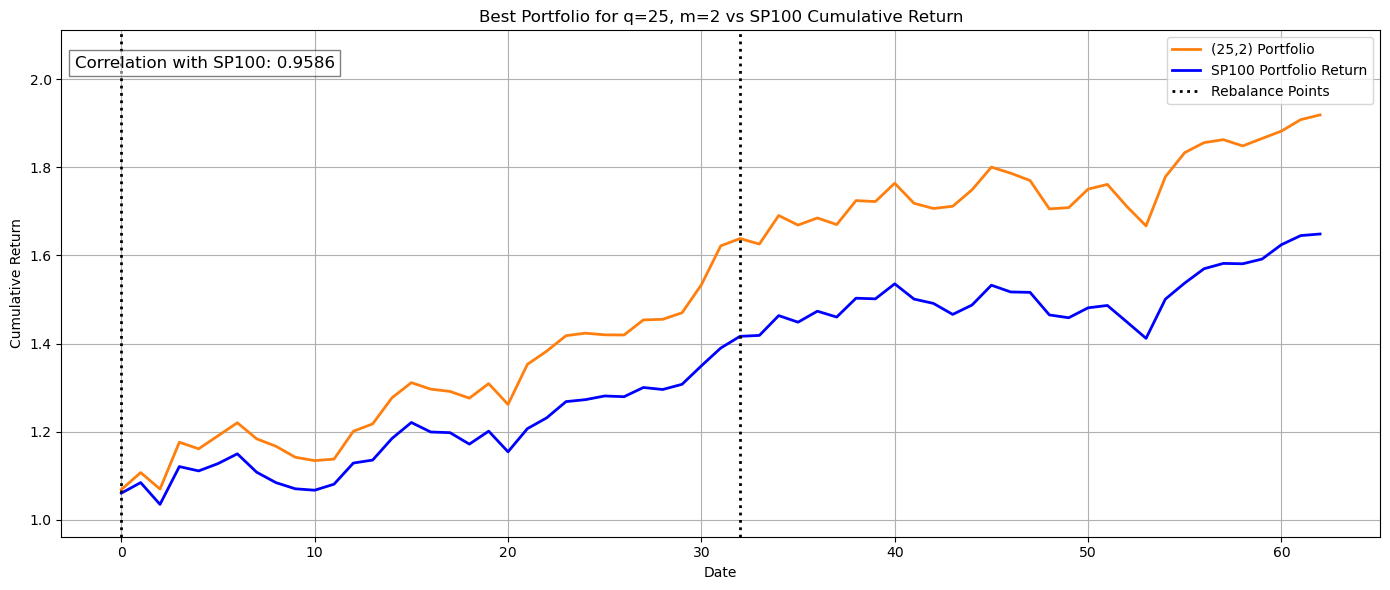

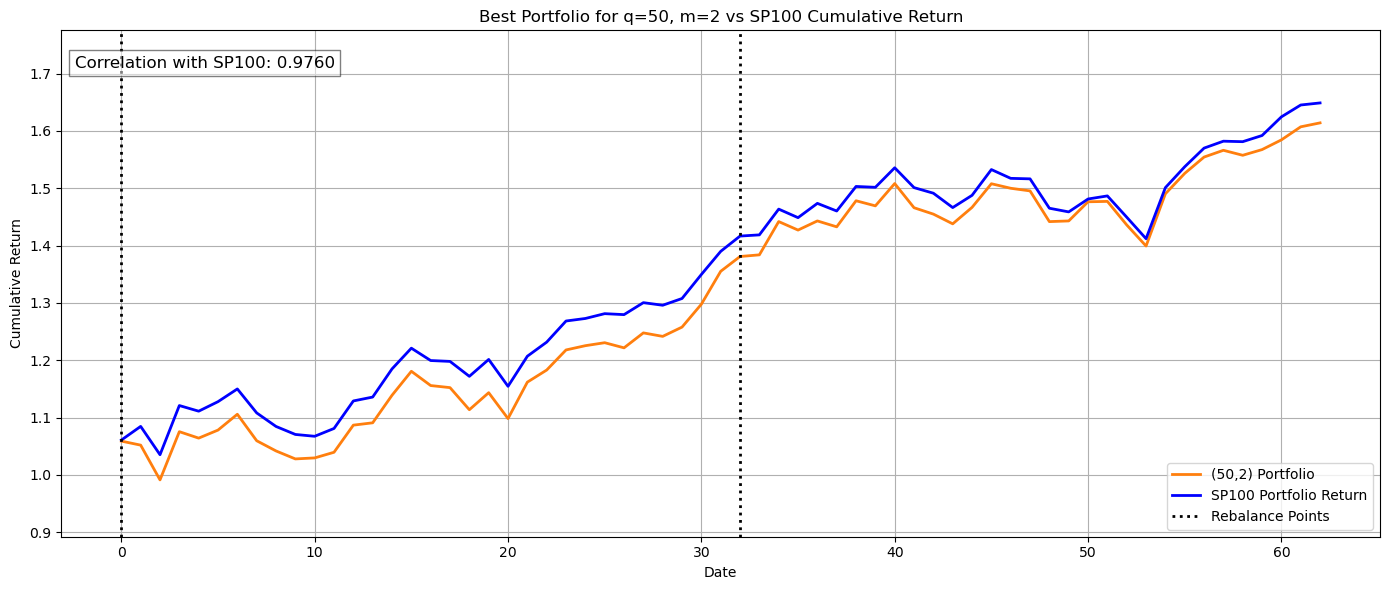

In [45]:
cumulative_indexes = (1 + indexes).cumprod()

# Plot the best portfolio for each q
for label in top_labels:
    focus_q, focus_m = eval(label)  # safe if coming from trusted source

    plt.figure(figsize=(14, 6))

    # Plot the highlighted portfolio (cumulative returns)
    plt.plot(cumulative_indexes.index, cumulative_indexes[label], label=f'{label} Portfolio', linewidth=2, color='tab:orange')

    # Plot SP100 (cumulative returns)
    plt.plot(cumulative_indexes.index, cumulative_indexes['SP100'], label='SP100 Portfolio Return', linewidth=2, linestyle='-', color='blue')

    # Calculate rebalance points based on m
    rebalance_points = list(range(0, len(cumulative_indexes), int(np.ceil(len(cumulative_indexes) / focus_m))))
    for x in rebalance_points:
        plt.axvline(x=x, color='black', linestyle=':', linewidth=2)
        
    rebalance_line = mlines.Line2D([], [], color='black', linestyle=':', linewidth=2, label='Rebalance Points')

    # Correlation annotation
    corr = corrs_df[(corrs_df['q'] == focus_q) & (corrs_df['m'] == focus_m)]['Correlation'].values[0]
    plt.text(
        0.01, 0.95, f'Correlation with SP100: {corr:.4f}',
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.5)
    )

    # Plot formatting
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.ylim(min(cumulative_indexes[label]) * .9, max(cumulative_indexes[label]) * 1.1)
    plt.title(f'Best Portfolio for q={focus_q}, m={focus_m} vs SP100 Cumulative Return')
    plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + [rebalance_line])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

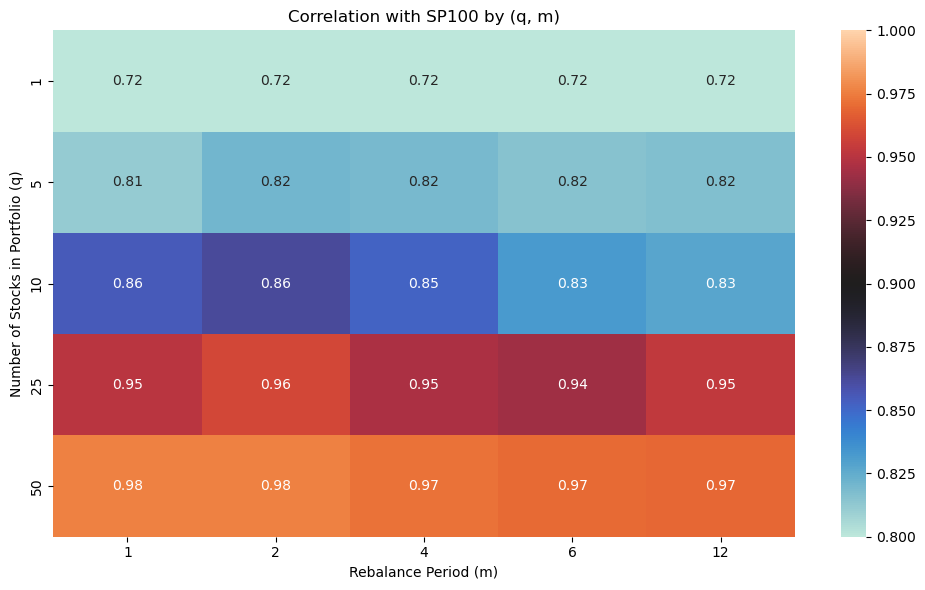

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the dataframe so rows are q, columns are m
pivot_table = corrs_df.pivot(index='q', columns='m', values='Correlation')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", center=0.9, vmin=.8, vmax=1  )
plt.title("Correlation with SP100 by (q, m)")
plt.xlabel("Rebalance Period (m)")
plt.ylabel("Number of Stocks in Portfolio (q)")
plt.tight_layout()
plt.show()


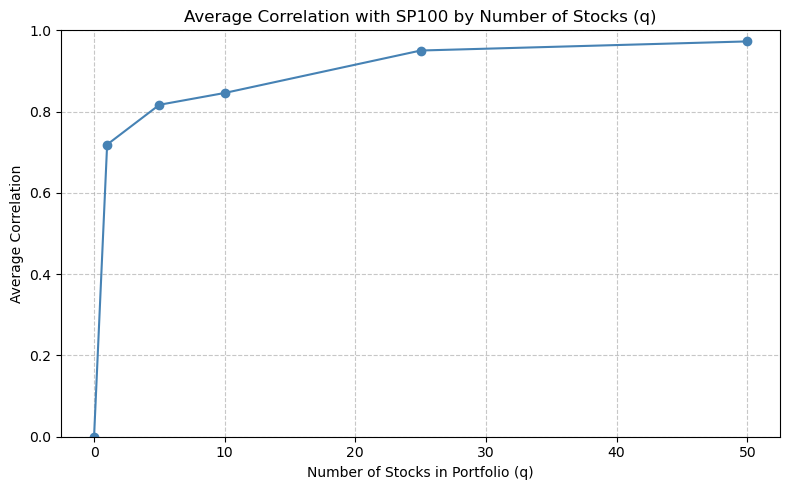

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by q and compute average correlation
avg_corr_by_q = corrs_df.groupby('q')['Correlation'].mean()

# Add (0, 0) to the beginning
avg_corr_by_q = pd.concat([
    pd.Series({0: 0.0}),
    avg_corr_by_q
])

# Line plot
plt.figure(figsize=(8, 5))
plt.plot(avg_corr_by_q.index, avg_corr_by_q.values, marker='o', linestyle='-', color='steelblue')

plt.title('Average Correlation with SP100 by Number of Stocks (q)')
plt.xlabel('Number of Stocks in Portfolio (q)')
plt.ylabel('Average Correlation')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
